# Statistics in `cytoflow`

One of the most powerful concepts in `cytoflow` is that it makes it easy to summarize your data, then track how those subsets change as your experimental variables change.  This notebook demonstrates several different modules that create and plot statistics.

---

Set up the Jupyter `matplotlib` integration, and import the `cytoflow` module.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import cytoflow as flow

We use the same data set as the **Yeast Dose Response** example notebook, with one variant: we load each tube three times, grabbing only 100 events from each.

In [2]:
inputs = {
    "Yeast_B1_B01.fcs" : 5.0,
    "Yeast_B2_B02.fcs" : 3.75,
    "Yeast_B3_B03.fcs" : 2.8125,
    "Yeast_B4_B04.fcs" : 2.109,
    "Yeast_B5_B05.fcs" : 1.5820,
    "Yeast_B6_B06.fcs" : 1.1865,
    "Yeast_B7_B07.fcs" : 0.8899,
    "Yeast_B8_B08.fcs" : 0.6674,
    "Yeast_B9_B09.fcs" : 0.5,
    "Yeast_B10_B10.fcs" : 0.3754,
    "Yeast_B11_B11.fcs" : 0.2816,
    "Yeast_B12_B12.fcs" : 0.2112,
    "Yeast_C1_C01.fcs" : 0.1584,
    "Yeast_C2_C02.fcs" : 0.1188,
    "Yeast_C3_C03.fcs" : 0.0892,
    "Yeast_C4_C04.fcs" : 0.0668,
    "Yeast_C5_C05.fcs" : 0.05,
    "Yeast_C6_C06.fcs" : 0.0376,
    "Yeast_C7_C07.fcs" : 0.0282,
    "Yeast_C8_C08.fcs" : 0.0211,
    "Yeast_C9_C09.fcs" : 0.0159
}

tubes = []
for filename, ip in inputs.iteritems():
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 1}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 2}))
    tubes.append(flow.Tube(file = "data/" + filename, conditions = {'IP' : ip, 'Replicate' : 3}))

    
ex = flow.ImportOp(conditions = {'IP' : "float", "Replicate" : "int"},
                   tubes = tubes,
                   coarse_events = 100).apply()

In `cytoflow`, a *statistic* is a value that summarizes something about some data.  For example, if we expect the geometric mean of `FITC-A` channel to change as the `IP` variable changes, we can compute those geometric means with the `ChannelStatisticOp` operation:

In [3]:
op = flow.ChannelStatisticOp(name = "ByIP",
                             by = ["IP"],
                             channel = "FITC-A",
                             function = flow.geom_mean)
ex2 = op.apply(ex)

This operation splits the data set by different values of `IP`, then applies the function `flow.geom_mean` to the `FITC-A` channel in each subset. The result is stored in the `statistics` attribute of the `Experiment` that it returns:

In [4]:
ex2.statistics

{('ByIP', 'geom_mean'): IP
 0.0159     113.634098
 0.0211     135.421498
 0.0282     162.819293
 0.0376     184.543063
 0.0500     268.780094
 0.0668     414.656073
 0.0892     658.794693
 0.1188     976.731819
 0.1584    1217.254603
 0.2112    1147.541585
 0.2816    1485.831511
 0.3754    1785.394228
 0.5000    1737.549772
 0.6674    2351.562197
 0.8899    2292.737718
 1.1865    2554.654204
 1.5820    2578.629892
 2.1090    2361.806179
 2.8125    2456.571978
 3.7500    2589.773925
 5.0000    2266.541756
 dtype: float64}

The `statistics` attribute is a dictionary.  The keys are tuples, where the first element in the tuple is the name of the operation that created the statistic, and the second element is specific to the operation.  The `Statistics1DOp` operation sets the second element of the tuple to the function name.  (You can override this by setting `Statistics1DOp.statistic_name`; this is useful if `function` is a lambda function.)

In [5]:
ex2.statistics.keys()

[('ByIP', 'geom_mean')]

The value of each entry in `Experiment.statistics` is a `pandas.Series`.  The series index is all the subsets for which the statistic was computed, and the contents are the values of the statstic itself.

In [6]:
ex2.statistics[('ByIP', 'geom_mean')]

IP
0.0159     113.634098
0.0211     135.421498
0.0282     162.819293
0.0376     184.543063
0.0500     268.780094
0.0668     414.656073
0.0892     658.794693
0.1188     976.731819
0.1584    1217.254603
0.2112    1147.541585
0.2816    1485.831511
0.3754    1785.394228
0.5000    1737.549772
0.6674    2351.562197
0.8899    2292.737718
1.1865    2554.654204
1.5820    2578.629892
2.1090    2361.806179
2.8125    2456.571978
3.7500    2589.773925
5.0000    2266.541756
dtype: float64

We can also specify multiple variables to break data set into.  In the example above, `Statistics1DOp` lumps all events with the same value of `IP` together, but each amount of `IP` actually has three values of `Replicate` as well.  Let's apply `geom_mean` to each unique combination of `IP` and `Replicate`:

In [7]:
op = flow.ChannelStatisticOp(name = "ByIP",
                             by = ["IP", "Replicate"],
                             channel = "FITC-A",
                             function = flow.geom_mean)
ex2 = op.apply(ex)
ex2.statistics[("ByIP", "geom_mean")][0:12]

IP      Replicate
0.0159  1            108.307994
        2            111.378785
        3            121.636250
0.0211  1            125.824316
        2            148.620696
        3            132.949299
0.0282  1            180.243329
        2            149.145732
        3            160.563773
0.0376  1            178.829867
        2            192.586557
        3            182.484991
dtype: float64

Note that the `pandas.Series` now has a `MultiIndex`: there are values for each unique combination of `IP` and `Replicate`.

---

Now that we have computed a statistic, we can plot it with one of the statistics views.  We can use a bar chart:

In [8]:
flow.BarChartView(statistic = ("ByIP", "geom_mean"),
                  variable = "IP").plot(ex2)

CytoflowViewError: Must use all the statistic indices as variables or facets: [u'IP', u'Replicate']

Oops!  Whenever we plot a statistic, we have to use *all* of the variables that were used to subdivide the experiment.  If the `Statistics1DOp` above had `by = ["IP", "Replicate"]`, then both `IP` and `Replicate` must either a plot variable or a plot facet.  Let's try it again:

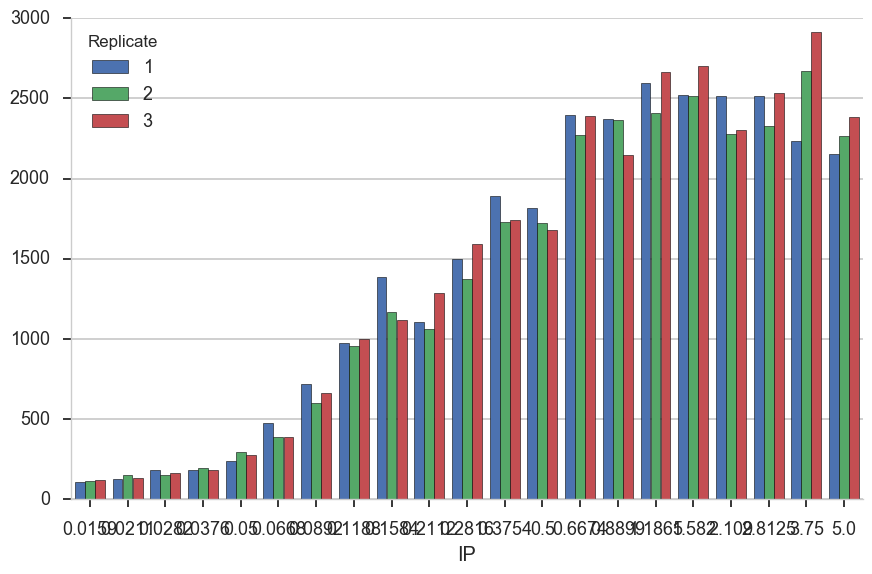

In [9]:
flow.BarChartView(statistic = ("ByIP", "geom_mean"),
                  variable = "IP",
                  huefacet = "Replicate").plot(ex2)

Bar charts are really best for categorical variables (with a modest number of categories.)  Let's do a line chart instead:

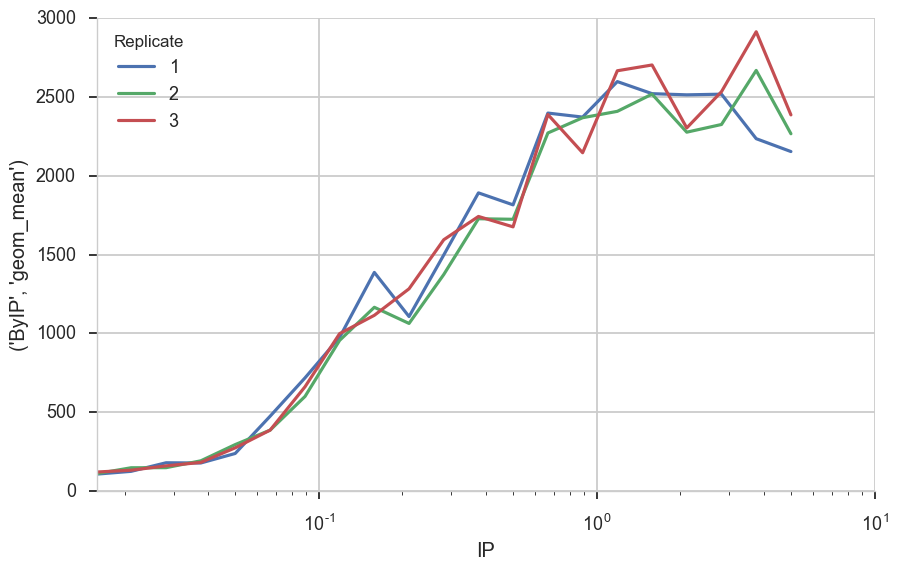

In [10]:
flow.Stats1DView(statistic = ("ByIP", "geom_mean"),
                 xvariable = "IP",
                 xscale = 'log',
                 huefacet = "Replicate").plot(ex2)

Statistics views can also plot error bars; the error bars must *also* be a statistic, and they must have the same indices as the "main" statistic.  For example, let's plot the geometric mean and geometric standard deviation of each IP subset:

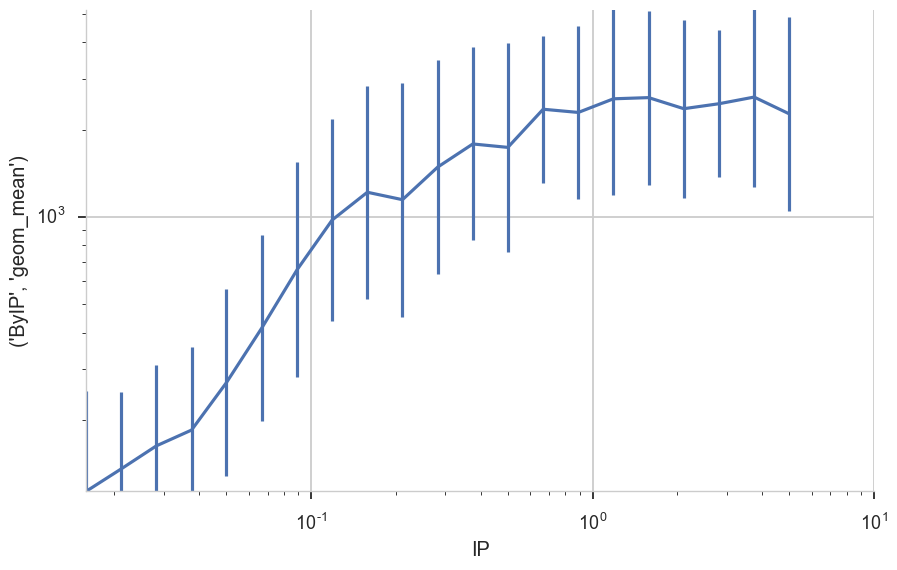

In [11]:
ex2 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ["IP"],
                              channel = "FITC-A",
                              function = flow.geom_mean).apply(ex)

# While an arithmetic SD is usually plotted plus-or-minus the arithmetic mean, 
# a *geometric* SD is usually plotted (on a log scale!) multiplied-or-divided by the 
# geometric mean.  the function geom_sd_range is a convenience function that does this.

ex3 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ['IP'],
                              channel = "FITC-A",
                              function = flow.geom_sd_range).apply(ex2)

flow.Stats1DView(statistic = ("ByIP", "geom_mean"),
                 xvariable = "IP",
                 xscale = "log",
                 yscale = "log",
                 error_statistic = ("ByIP", "geom_sd_range")).plot(ex3)

The plot above shows how one statistic varies (on the Y axis) as a variable changes on the X axis.  We can also plot two statistics against eachother.  For example, we can ask if the geometric standard deviation varies as the geometric mean changes:

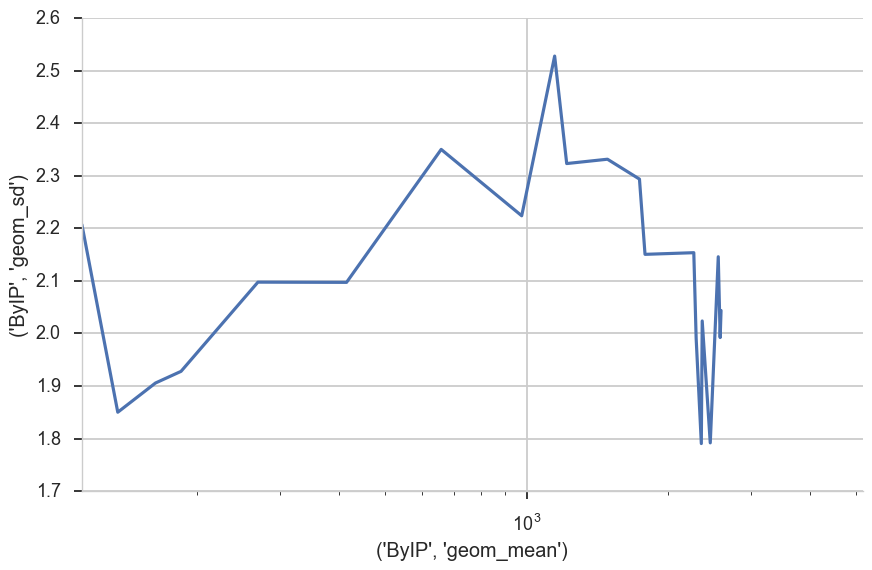

In [12]:
ex2 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ["IP"],
                              channel = "FITC-A",
                              function = flow.geom_mean).apply(ex)

ex3 = flow.ChannelStatisticOp(name = "ByIP",
                              by = ['IP'],
                              channel = "FITC-A",
                              function = flow.geom_sd).apply(ex2)

flow.Stats2DView(variable = "IP",
                 xstatistic = ("ByIP", "geom_mean"),
                 ystatistic = ("ByIP", "geom_sd"),
                 xscale = "log").plot(ex3)

Nope, guess not.  See the **TASBE Calibrated Flow Cytometry** notebook for more examples of 1D and 2D statistics views.

---

In addition to making statistics by applying summary functions to data, you can also apply functions to other statistics.  For example, a common question is "What percentage of my events are in a particular gate?"  We could, for instance, ask what percentage of events are above 1000 in the `FITC-A` channel, and how that varies by amount of `IP`. We start by defining a *threshold* gate with `ThresholdOp`:

In [13]:
thresh = flow.ThresholdOp(name = "Above1000",
                          channel = "FITC-A",
                          threshold = 1000)
ex2 = thresh.apply(ex)

Now, the Experiment has a column named `Above1000` that is `true` or `false` depending on whether that event's `FITC-A` channel is greater than 1000.  Next, we compute the total number of events in each subset with a unique combination of `Above1000` and `IP`:

In [14]:
import numpy as np

ex3 = flow.ChannelStatisticOp(name = "Above1000",
                              by = ["Above1000", "IP"],
                              channel = "FITC-A",
                              function = len).apply(ex2)
ex3.statistics[("Above1000", "len")]

Above1000  IP    
False      0.0159    299
           0.0211    300
           0.0282    299
           0.0376    299
           0.0500    295
           0.0668    270
           0.0892    198
           0.1188    152
           0.1584    104
           0.2112    103
           0.2816     67
           0.3754     48
           0.5000     59
           0.6674     23
           0.8899     24
           1.1865     22
           1.5820     18
           2.1090     26
           2.8125     22
           3.7500     13
           5.0000     33
True       0.0159      1
           0.0211      0
           0.0282      1
           0.0376      1
           0.0500      5
           0.0668     30
           0.0892    102
           0.1188    148
           0.1584    196
           0.2112    197
           0.2816    233
           0.3754    252
           0.5000    241
           0.6674    277
           0.8899    276
           1.1865    278
           1.5820    282
           2.1090    274
       

And now we compute the percentage of `Above1000 == True` for each value of `IP`:

In [24]:
import pandas as pd

ex4 = flow.TransformStatisticOp(name = "Above1000",
                                statistic = ("Above1000", "len"),
                                by = ["IP"],
                                function = lambda a: pd.Series(a / a.sum()),
                                statistic_name = "percent").apply(ex3)

ex4.statistics[("Above1000", "percent")]

IP      Above1000
0.0159  False        0.996667
        True         0.003333
0.0211  False        1.000000
        True         0.000000
0.0282  False        0.996667
        True         0.003333
0.0376  False        0.996667
        True         0.003333
0.0500  False        0.983333
        True         0.016667
0.0668  False        0.900000
        True         0.100000
0.0892  False        0.660000
        True         0.340000
0.1188  False        0.506667
        True         0.493333
0.1584  False        0.346667
        True         0.653333
0.2112  False        0.343333
        True         0.656667
0.2816  False        0.223333
        True         0.776667
0.3754  False        0.160000
        True         0.840000
0.5000  False        0.196667
        True         0.803333
0.6674  False        0.076667
        True         0.923333
0.8899  False        0.080000
        True         0.920000
1.1865  False        0.073333
        True         0.926667
1.5820  False        0

                       NaN
IP     Above1000          
0.0159 False      0.996667
       True       0.003333
0.0211 False      1.000000
       True       0.000000
0.0282 False      0.996667
       True       0.003333
0.0376 False      0.996667
       True       0.003333
0.0500 False      0.983333
       True       0.016667
0.0668 False      0.900000
       True       0.100000
0.0892 False      0.660000
       True       0.340000
0.1188 False      0.506667
       True       0.493333
0.1584 False      0.346667
       True       0.653333
0.2112 False      0.343333
       True       0.656667
0.2816 False      0.223333
       True       0.776667
0.3754 False      0.160000
       True       0.840000
0.5000 False      0.196667
       True       0.803333
0.6674 False      0.076667
       True       0.923333
0.8899 False      0.080000
       True       0.920000
1.1865 False      0.073333
       True       0.926667
1.5820 False      0.060000
       True       0.940000
2.1090 False      0.086667
 

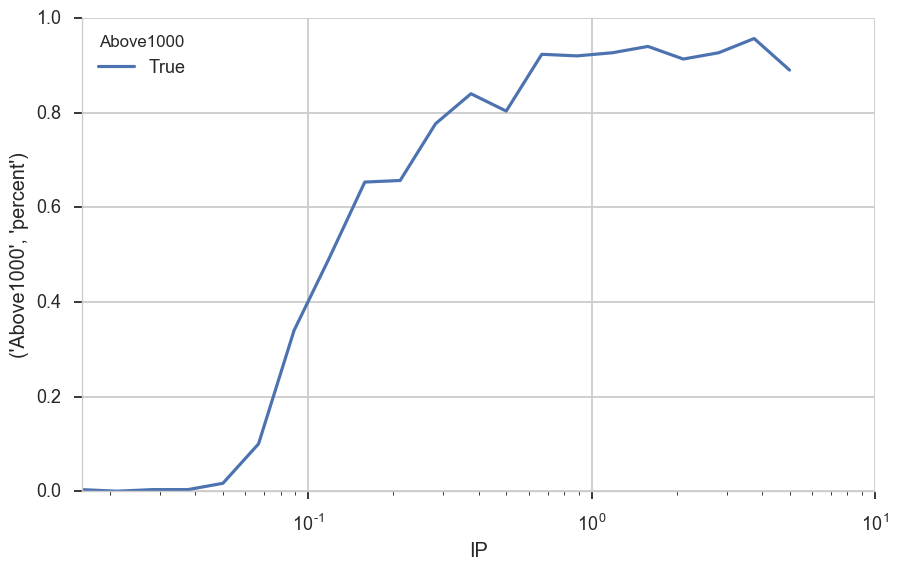

In [35]:
flow.Stats1DView(statistic = ("Above1000", "percent"),
                 xvariable = "IP",
                 xscale = "log",
                 huefacet = "Above1000",
                 subset = "Above1000 == True").plot(ex4)

One of the most exciting aspects of statistics in `cytoflow` is that other data-driven modules can add them to an `Experiment`, too.  For example, the `GaussianMixture1DOp` adds several statistics for each component of the mixture model it fits, containing the mean, standard deviation and proportion of observations in each component: